In [3]:
from sklearn.metrics import recall_score
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
from collections import Counter
from tqdm import tqdm

In [4]:
files_dir = '../../teams/DSC180B_WI22_A00/b11group2/actigraphy/'
all_files = os.listdir(files_dir)
# Might need to change these numbers 
N_train = 1500
N_test = 500
# Reading all the files
train_data = [pd.read_csv(files_dir+i) for i in all_files[:N_train]]
test_data = [pd.read_csv(files_dir+i) for i in all_files[N_train:]]

In [5]:
def data_preproc(raw_df):
    '''Takes in the raw df and outputs df ready to put into the classifier'''
    
    df = raw_df.drop(['pid', 'sawa2'], axis = 1)

    df = df.loc[df.interval != 'EXCLUD'].reset_index(drop = True)

    df['interval_num'] = df.interval.replace({'ACTIVE': 3, 'REST': 1, 'REST-S': 0}) # so the differences are unique

    epochs_in_each_interval = (df.loc[df.interval_num.diff() != 0, :] # epochs where state changed
                               .line
                               .diff()) # number of epochs in each state, starting from active

    # interval_epochs eventually contains 1) indicies where state changes, 2) what interval starts at that epoch,  
    # 3) num of epochs in the state before it and 4) the num of epochs in that state itself
    interval_epochs = (df.iloc[epochs_in_each_interval.index,:].interval_num.to_frame()
                       .join(epochs_in_each_interval).reset_index())
    interval_epochs.columns = ['index', 'interval_num', 'num_epochs_before_interval']
    interval_epochs['num_epochs_in_interval'] = interval_epochs.num_epochs_before_interval[1:].reset_index(drop=True)

    # indicies where active (3) starts or sleeping (0) starts
    active_sleep_idx = list(interval_epochs.loc[(interval_epochs.interval_num == 0) | 
                                                (interval_epochs.interval_num == 3)]['index'])

    # indicies where active starts
    active_idx = interval_epochs.loc[interval_epochs.interval_num == 3].index

    sleep_eff = [] # will contain sleep efficiency for the different times that subject sleeps
    num_epochs_in_interval = interval_epochs.num_epochs_in_interval

    for i in range(len(interval_epochs)):
        if interval_epochs.iloc[i, 1] == 0:
            if interval_epochs.iloc[i-1, 1] == 1:
                sleep_eff.append(interval_epochs.iloc[i, 3]/(interval_epochs.iloc[i-1, 3]+interval_epochs.iloc[i, 3]))
            else:
                sleep_eff.append(1)
                
    # indicies where light exposure occurs before the subject sleeps (active + rest)
    awake_light_idx = []
    for i in range(interval_epochs.shape[0]):
        if interval_epochs.iloc[i, 1] == 0:
            if interval_epochs.iloc[i-1, 1] == 1:
                awake_light_idx.append(tuple((interval_epochs.iloc[i-2, 0], interval_epochs.iloc[i, 0])))
            else:
                awake_light_idx.append(tuple((interval_epochs.iloc[i-1, 0], interval_epochs.iloc[i, 0])))

                # series with series of light (this is the format that sktime dfs take)
    awake_whitelight_series = pd.Series([df.whitelight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                         for x,y in awake_light_idx]) # light for last 2 hours before sleep only
    awake_bluelight_series = pd.Series([df.bluelight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                        for x,y in awake_light_idx])
    awake_greenlight_series = pd.Series([df.greenlight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                         for x,y in awake_light_idx])
    awake_redlight_series = pd.Series([df.redlight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                       for x,y in awake_light_idx])

    # each entry in column dim_xxxx is a series of light
    final_df = pd.DataFrame({"dim_white": awake_whitelight_series.values, 
                             "dim_blue": awake_bluelight_series.values,
                             "dim_green": awake_greenlight_series.values,
                             "dim_red": awake_redlight_series.values,
                             "sleep_eff": sleep_eff})

    # threshold chosen using idea that good sleep efficiency is when one sleeps in ~24 mins
    # for a sleep of 8 hrs (ratio -- 24mins/8hrs = 3mins/1hr)
    final_df["sleep_eff_cat"] = (final_df.sleep_eff >= 0.95).replace({True: "Good", False: "Bad"})

    return final_df

In [6]:
def concat_proc_data(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    concat_df = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        concat_df = pd.concat([concat_df, proc_data])
    concat_df = concat_df.reset_index(drop = True)
    concat_df = concat_df.loc[concat_df.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    return concat_df

In [7]:
def concat_proc_data_act(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    mean_act = pd.Series([df.activity.mean() for df in raw_data_lst])
    MEDIAN_ACTIVITY = mean_act.median()
    
    concat_df_act_less = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    concat_df_act_more = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        if df.activity.mean() <= MEDIAN_ACTIVITY:
            concat_df_act_less = pd.concat([concat_df_act_less, proc_data])
        else:
            concat_df_act_more = pd.concat([concat_df_act_more, proc_data])
            
    concat_df_act_less = concat_df_act_less.reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.reset_index(drop = True)
    
    concat_df_act_less = concat_df_act_less.loc[concat_df_act_less.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.loc[concat_df_act_more.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    
    return concat_df_act_less, concat_df_act_more

In [8]:
def concat_proc_data_sleep(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    sleep_total = pd.Series([(df.interval == 'REST-S').sum() / 120 for df in train_data])
    MEDIAN_SLEEP = sleep_total.median()
    
    concat_df_act_less = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    concat_df_act_more = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        if (df.interval == 'REST-S').sum() / 120 <= MEDIAN_SLEEP:
            concat_df_act_less = pd.concat([concat_df_act_less, proc_data])
        else:
            concat_df_act_more = pd.concat([concat_df_act_more, proc_data])
            
    concat_df_act_less = concat_df_act_less.reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.reset_index(drop = True)
    
    concat_df_act_less = concat_df_act_less.loc[concat_df_act_less.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.loc[concat_df_act_more.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    
    return concat_df_act_less, concat_df_act_more

In [9]:
def split_X_y(df):
    '''Split X features and y outcome.'''
    return (df.iloc[:, :4], df.iloc[:, 5])

In [10]:
def most_common(lst):
#     return max(set(lst), key=lst.count)
    data = Counter(lst[::-1])
    return max(lst[::-1], key=data.get)

In [9]:
train_preproc = concat_proc_data(train_data)
test_preproc = concat_proc_data(test_data)

In [10]:
test_preproc.sleep_eff_cat.value_counts(normalize = True)

Good    0.868807
Bad     0.131193
Name: sleep_eff_cat, dtype: float64

In [16]:
corrs_green_blue = []
corrs_green_red = []
corrs_red_blue = []
corrs_white_blue = []
corrs_white_red = []
corrs_white_green = []
for i in tqdm(range(train_preproc.shape[0])):
    corrs_green_blue.append(train_preproc.dim_green[i].corr(train_preproc.dim_blue[i]))
    corrs_green_red.append(train_preproc.dim_green[i].corr(train_preproc.dim_red[i]))
    corrs_red_blue.append(train_preproc.dim_red[i].corr(train_preproc.dim_blue[i]))
    corrs_white_blue.append(train_preproc.dim_blue[i].corr(train_preproc.dim_white[i]))
    corrs_white_red.append(train_preproc.dim_white[i].corr(train_preproc.dim_red[i]))
    corrs_white_green.append(train_preproc.dim_white[i].corr(train_preproc.dim_green[i]))

100%|██████████| 12654/12654 [00:12<00:00, 1012.67it/s]


In [17]:
print(pd.Series(corrs_green_blue).dropna().abs().quantile(.025), pd.Series(corrs_green_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_green_red).dropna().abs().quantile(.025), pd.Series(corrs_green_red).dropna().abs().quantile(.975))
print(pd.Series(corrs_red_blue).dropna().abs().quantile(.025), pd.Series(corrs_red_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_blue).dropna().abs().quantile(.025), pd.Series(corrs_white_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_red).dropna().abs().quantile(.025), pd.Series(corrs_white_red).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_green).dropna().abs().quantile(.025), pd.Series(corrs_white_green).dropna().abs().quantile(.975))

0.6269639270970362 0.9962928355070373
0.5030370509173947 0.9899357673955437
0.2352404791506124 0.979465538289955
0.5952986904955827 0.9949872279536573
0.6614508103224416 0.9941359621154074
0.9512654443068823 0.9998637286994772


In [18]:
print(pd.Series(corrs_green_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_green_red).dropna().abs().quantile(.5))
print(pd.Series(corrs_red_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_red).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_green).dropna().abs().quantile(.5))

0.9366062547938862
0.8881894072085672
0.734990341243779
0.9113660159517373
0.9344267827611874
0.9950526013580665


In [38]:
train_good = train_preproc.loc[train_preproc.sleep_eff_cat == 'Good']
train_bad = train_preproc.loc[train_preproc.sleep_eff_cat == 'Bad']
train_balanced = pd.concat([train_good.sample(train_bad.shape[0]), train_bad]).reset_index(drop = True)

In [39]:
train_preproc_X, train_preproc_y = split_X_y(train_balanced)
test_preproc_X, test_preproc_y = split_X_y(test_preproc)

In [ ]:
# train_preproc_X#.dim_blue

In [40]:
from sktime.classification.kernel_based import RocketClassifier
# from sktime.transformations.panel.rocket import Rocket

In [15]:
rocket = RocketClassifier()
rocket.fit(train_preproc_X.dim_white.to_frame(), train_preproc_y)

with open('models/rocket_model_white_only.pkl','wb') as f:
    pickle.dump(rocket, f)
    
y_pred = rocket.predict(test_preproc_X.dim_white.to_frame())
recall_score(test_preproc_y, y_pred, pos_label = "Bad") 

0.627039627039627

In [41]:
# Load different models
with open('models/rocket_model.pkl', 'rb') as f:
    rocket_overall = pickle.load(f)

with open('models/rocket_model_blue_only.pkl', 'rb') as f:
    rocket_blue = pickle.load(f)

with open('models/rocket_model_red_only.pkl', 'rb') as f:
    rocket_red = pickle.load(f)

with open('models/rocket_model_green_only.pkl', 'rb') as f:
    rocket_green = pickle.load(f)

with open('models/rocket_model_white_only.pkl', 'rb') as f:
    rocket_white = pickle.load(f)
    
rocket_models = [rocket_overall, rocket_red, rocket_blue, rocket_green, rocket_white]

In [28]:
y_pred = rocket_models[0].predict(test_preproc_X)#.dim_white.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6363636363636364 0.5772615276311158


In [29]:
y_pred = rocket_models[1].predict(test_preproc_X.dim_red.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6317016317016317 0.5955649419218585


In [30]:
y_pred = rocket_models[2].predict(test_preproc_X.dim_blue.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.5920745920745921 0.5807814149947201


In [31]:
y_pred = rocket_models[3].predict(test_preproc_X.dim_green.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6386946386946387 0.6043646603308694


In [32]:
y_pred = rocket_models[4].predict(test_preproc_X.dim_white.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.627039627039627 0.6156282998944034


In [44]:
pd.Series(y_pred).value_counts(normalize = True)

Good    0.583792
Bad     0.416208
dtype: float64

In [46]:
original_test_X = test_preproc_X
original_test_y = test_preproc_y

In [42]:
def filterPreds(X, y, preds, label = 'Good'):
    ser = pd.Series(preds)
    return (X.loc[ser == label].reset_index(drop = True), y.loc[ser == label].reset_index(drop = True))

In [16]:
first_preds = rocket_models[1].predict(original_test_X.dim_red.to_frame())

_, first_bad = filterPreds(original_test_X, original_test_y, first_preds, 'Bad')
second_X, second_good = filterPreds(original_test_X, original_test_y, first_preds, 'Good')

second_preds = rocket_models[2].predict(second_X.dim_blue.to_frame())

_, second_bad = filterPreds(second_X, second_good, second_preds, 'Bad')
third_X, third_good = filterPreds(second_X, second_good, second_preds, 'Good')

third_preds = rocket_models[3].predict(third_X.dim_green.to_frame())

_, third_bad = filterPreds(third_X, third_good, third_preds, 'Bad')
fourth_X, fourth_good = filterPreds(third_X, third_good, third_preds, 'Good')

fourth_preds = rocket_models[4].predict(fourth_X.dim_white.to_frame())

recall_score(list(first_bad) + list(second_bad) + list(third_bad) + list(fourth_good), 
            ['Bad']*(len(first_bad) + len(second_bad) + len(third_bad)) + list(fourth_preds), pos_label = 'Bad')

0.8554778554778555

In [62]:
f1_score(list(first_bad) + list(second_bad) + list(third_bad) + list(fourth_good), 
            ['Bad']*(len(first_bad) + len(second_bad) + len(third_bad)) + list(fourth_preds), pos_label = 'Good')

0.4939040207522698

In [44]:
def model_preds(X):
    preds_1 = rocket_models[1].predict(X.dim_red.to_frame())
    preds_2 = rocket_models[2].predict(X.dim_blue.to_frame())
    preds_3 = rocket_models[3].predict(X.dim_green.to_frame())
    preds_4 = rocket_models[4].predict(X.dim_white.to_frame())
    pred_df = pd.DataFrame({'red_pred': preds_1, 
                            'blue_pred': preds_2, 
                            'green_pred': preds_3, 
                            'white_pred': preds_4})
#     model_preds = pred_df.apply(lambda row: most_common(list(row)), axis = 1)
    return pred_df

In [47]:
model_preds_f = model_preds(original_test_X)

In [52]:
original_test_X.shape[0] * 0.1

327.0

In [55]:
red_recalls = []
blue_recalls = []
green_recalls = []
for _ in tqdm(range(100)):
    test_preproc_samples = [test_preproc.sample(frac = 0.1, replace = True) for _ in range(3)]
    test_preproc_X_y_samples = [split_X_y(df) for df in test_preproc_samples]
    preds_red_samp = rocket_models[1].predict(test_preproc_X_y_samples[0][0].dim_red.to_frame())
    preds_blue_samp = rocket_models[2].predict(test_preproc_X_y_samples[1][0].dim_blue.to_frame())
    preds_green_samp = rocket_models[3].predict(test_preproc_X_y_samples[2][0].dim_green.to_frame())
    red_recalls.append(recall_score(test_preproc_X_y_samples[0][1], preds_red_samp, pos_label = 'Bad'))
    blue_recalls.append(recall_score(test_preproc_X_y_samples[1][1], preds_blue_samp, pos_label = 'Bad'))
    green_recalls.append(recall_score(test_preproc_X_y_samples[2][1], preds_green_samp, pos_label = 'Bad'))

100%|██████████| 100/100 [40:08<00:00, 24.08s/it]


In [11]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

(array([ 2.,  5.,  4., 12., 17., 13., 22., 13.,  5.,  7.]),
 array([0.43181818, 0.45974747, 0.48767677, 0.51560606, 0.54353535,
        0.57146465, 0.59939394, 0.62732323, 0.65525253, 0.68318182,
        0.71111111]),
 <BarContainer object of 10 artists>)

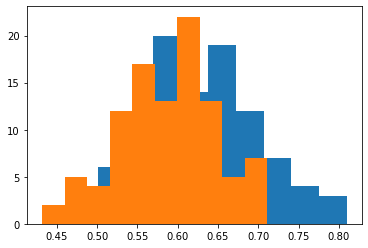

In [65]:
plt.hist(pd.Series(red_recalls))
plt.hist(pd.Series(blue_recalls))

In [59]:
ks_2samp(red_recalls, blue_recalls)

KstestResult(statistic=0.26, pvalue=0.002219935934558366)

(array([ 2.,  4., 10., 14., 16., 18., 17.,  8.,  6.,  5.]),
 array([0.44444444, 0.47954545, 0.51464646, 0.54974747, 0.58484848,
        0.61994949, 0.65505051, 0.69015152, 0.72525253, 0.76035354,
        0.79545455]),
 <BarContainer object of 10 artists>)

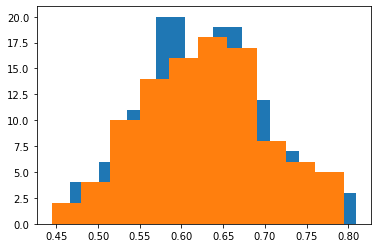

In [66]:
plt.hist(pd.Series(red_recalls))
plt.hist(pd.Series(green_recalls))

In [68]:
ks_2samp(green_recalls, red_recalls)

KstestResult(statistic=0.08, pvalue=0.9084105017744525)

(array([ 2.,  4., 10., 14., 16., 18., 17.,  8.,  6.,  5.]),
 array([0.44444444, 0.47954545, 0.51464646, 0.54974747, 0.58484848,
        0.61994949, 0.65505051, 0.69015152, 0.72525253, 0.76035354,
        0.79545455]),
 <BarContainer object of 10 artists>)

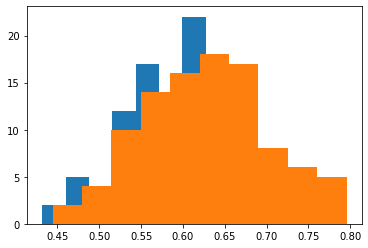

In [69]:
plt.hist(pd.Series(blue_recalls))
plt.hist(pd.Series(green_recalls))

In [70]:
ks_2samp(green_recalls, blue_recalls)

KstestResult(statistic=0.32, pvalue=6.281176788972264e-05)

In [71]:
pd.Series(blue_recalls).mean(), pd.Series(green_recalls).mean(), pd.Series(red_recalls).mean()

(0.5881414624668633, 0.6282914148043014, 0.6266733863559213)

In [49]:
recall_score(original_test_y, model_preds_f.red_pred, pos_label = 'Bad')

0.6317016317016317

In [72]:
recall_score(pred_df.true, model_preds_f, pos_label = 'Bad'), recall_score(pred_df.true, model_preds_f, pos_label = 'Good')

(0.6317016317016317, 0.6209081309398099)

In [42]:
overall_preds = rocket_models[0].predict(original_test_X)
print(recall_score(pred_df.true, overall_preds, pos_label = 'Good'), recall_score(pred_df.true, overall_preds, pos_label = 'Bad'))

0.5772615276311158 0.6363636363636364


In [63]:
first_preds = rocket_models[1].predict(original_test_X.dim_red.to_frame())

_, first_bad = filterPreds(original_test_X, original_test_y, first_preds, 'Good')
second_X, second_good = filterPreds(original_test_X, original_test_y, first_preds, 'Bad')

second_preds = rocket_models[2].predict(second_X.dim_blue.to_frame())

_, second_bad = filterPreds(second_X, second_good, second_preds, 'Good')
third_X, third_good = filterPreds(second_X, second_good, second_preds, 'Bad')

third_preds = rocket_models[3].predict(third_X.dim_green.to_frame())

_, third_bad = filterPreds(third_X, third_good, third_preds, 'Good')
fourth_X, fourth_good = filterPreds(third_X, third_good, third_preds, 'Bad')

fourth_preds = rocket_models[4].predict(fourth_X.dim_white.to_frame())

recall_score(list(first_bad) + list(second_bad) + list(third_bad) + list(fourth_good), 
            ['Good']*(len(first_bad) + len(second_bad) + len(third_bad)) + list(fourth_preds), pos_label = 'Good')

0.8303414290742697

In [10]:
train_preproc_act_less, train_preproc_act_more = concat_proc_data_act(train_data)
test_preproc_act_less, test_preproc_act_more = concat_proc_data_act(test_data)

In [11]:
test_preproc_act_less_X, test_preproc_act_less_y = split_X_y(test_preproc_act_less)
test_preproc_act_more_X, test_preproc_act_more_y = split_X_y(test_preproc_act_more)

In [12]:
act_less_preds = model_preds(test_preproc_act_less_X)
act_more_preds = model_preds(test_preproc_act_more_X)

In [13]:
recall_score(test_preproc_act_less_y, act_less_preds, pos_label = 'Bad'), recall_score(test_preproc_act_less_y, act_less_preds, pos_label = 'Good')

(0.6142857142857143, 0.6227208976157083)

In [14]:
recall_score(test_preproc_act_more_y, act_more_preds, pos_label = 'Bad'), recall_score(test_preproc_act_more_y, act_more_preds, pos_label = 'Good')

(0.6484018264840182, 0.6190812720848057)

In [23]:
train_preproc_sleep_less, train_preproc_sleep_more = concat_proc_data_sleep(train_data)
test_preproc_sleep_less, test_preproc_sleep_more = concat_proc_data_sleep(test_data)

test_preproc_sleep_less_X, test_preproc_sleep_less_y = split_X_y(test_preproc_sleep_less)
test_preproc_sleep_more_X, test_preproc_sleep_more_y = split_X_y(test_preproc_sleep_more)

sleep_less_preds = model_preds(test_preproc_sleep_less_X)
sleep_more_preds = model_preds(test_preproc_sleep_more_X)

In [24]:
recall_score(test_preproc_sleep_less_y, sleep_less_preds, pos_label = 'Bad'), recall_score(test_preproc_sleep_less_y, sleep_less_preds, pos_label = 'Good')

(0.6536796536796536, 0.6609918578830496)

In [25]:
recall_score(test_preproc_sleep_more_y, sleep_more_preds, pos_label = 'Bad'), recall_score(test_preproc_sleep_more_y, sleep_more_preds, pos_label = 'Good')

(0.6060606060606061, 0.5845637583892618)

# Rough work

In [253]:
X, y = load_arrow_head()
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

In [254]:
df1 = load_arrow_head()
df2 = load_basic_motions()

In [276]:
final_df#.dim_0

,dim_0,sleep_eff
0,0 44.34 1 71.93 2 61.29 3 ...,0.789474
1,0 1.01 1 1.02 2 1.18 3 1.5...,0.922794
2,0 6.29 1 4.76 2 2.05 3 ...,0.998336
3,0 2.83 1 3.49 2 87.61 3...,0.989088
4,0 27.25 1 0.55 2 0.51 3 ...,0.911921
5,0 149.01 1 123.26 2 346.73 3...,0.997735
6,0 0.51 1 0.48 2 22.50 3 ...,0.996491
7,0 0.51 1 0.51 2 12.93 3 ...,0.992695
8,0 0.51 1 0.51 2 0.51 3 ...,0.982264
9,0 7.45 1 6.75 2 8.77 3 ...,0.889397


In [271]:
df1#.iloc[0,0]

,dim_0,class_val
0,0 -1.9630 1 -1.9578 2 -1.9561 3 ...,0
1,0 -1.7746 1 -1.7740 2 -1.7766 3 ...,1
2,0 -1.8660 1 -1.8420 2 -1.8350 3 ...,2
3,0 -2.0738 1 -2.0733 2 -2.0446 3 ...,0
4,0 -1.7463 1 -1.7413 2 -1.7227 3 ...,1
...,...,...
170,0 -1.6251 1 -1.6230 2 -1.6261 3 ...,2
171,0 -1.6578 1 -1.6647 2 -1.6326 3 ...,2
172,0 -1.6033 1 -1.5874 2 -1.5774 3 ...,2
173,0 -1.7390 1 -1.7415 2 -1.7329 3 ...,2


In [52]:
df2

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,class_val
0,0 0.079106 1 0.079106 2 -0.903497 3...,0 0.394032 1 0.394032 2 -3.666397 3...,0 0.551444 1 0.551444 2 -0.282844 3...,0 0.351565 1 0.351565 2 -0.095881 3...,0 0.023970 1 0.023970 2 -0.319605 3...,0 0.633883 1 0.633883 2 0.972131 3...,standing
1,0 0.377751 1 0.377751 2 2.952965 3...,0 -0.610850 1 -0.610850 2 0.970717 3...,0 -0.147376 1 -0.147376 2 -5.962515 3...,0 -0.103872 1 -0.103872 2 -7.593275 3...,0 -0.109198 1 -0.109198 2 -0.697804 3...,0 -0.037287 1 -0.037287 2 -2.865789 3...,standing
2,0 -0.813905 1 -0.813905 2 -0.424628 3...,0 0.825666 1 0.825666 2 -1.305033 3...,0 0.032712 1 0.032712 2 0.826170 3...,0 0.021307 1 0.021307 2 -0.372872 3...,0 0.122515 1 0.122515 2 -0.045277 3...,0 0.775041 1 0.775041 2 0.383526 3...,standing
3,0 0.289855 1 0.289855 2 -0.669185 3...,0 0.284130 1 0.284130 2 -0.210466 3...,0 0.213680 1 0.213680 2 0.252267 3...,0 -0.314278 1 -0.314278 2 0.018644 3...,0 0.074574 1 0.074574 2 0.007990 3...,0 -0.079901 1 -0.079901 2 0.237040 3...,standing
4,0 -0.123238 1 -0.123238 2 -0.249547 3...,0 0.379341 1 0.379341 2 0.541501 3...,0 -0.286006 1 -0.286006 2 0.208420 3...,0 -0.098545 1 -0.098545 2 -0.023970 3...,0 0.058594 1 0.058594 2 0.175783 3...,0 -0.074574 1 -0.074574 2 0.114525 3...,standing
...,...,...,...,...,...,...,...
35,0 -0.040961 1 -0.040961 2 0.338414 3...,0 -0.971100 1 -0.971100 2 -3.420216 3...,0 0.203560 1 0.203560 2 -2.053446 3...,0 0.061258 1 0.061258 2 0.250357 3...,0 -0.047941 1 -0.047941 2 -0.639209 3...,0 0.961478 1 0.961478 2 -0.298298 3...,badminton
36,0 -1.801504 1 -1.801504 2 -0.480725 3...,0 2.344990 1 2.344990 2 -0.994385 3...,0 0.281253 1 0.281253 2 0.378807 3...,0 0.716447 1 0.716447 2 -0.870923 3...,0 0.162466 1 0.162466 2 0.095881 3...,0 0.921527 1 0.921527 2 -0.474080 3...,badminton
37,0 -0.046089 1 -0.283051 2 -0.587748 3...,0 -0.738026 1 -0.314572 2 3.388108 3...,0 0.179667 1 -0.724257 2 -0.223563 3...,0 0.364882 1 -1.163894 2 -2.543521 3...,0 -0.237040 1 -0.101208 2 0.402169 3...,0 0.386189 1 -0.165129 2 -0.897557 3...,badminton
38,0 -2.178746 1 -2.178746 2 -0.448056 3...,0 -0.385371 1 -0.385371 2 -2.08943...,0 -0.805837 1 -0.805837 2 1.04617...,0 -0.039951 1 -0.039951 2 1.946925 3...,0 0.484734 1 0.484734 2 -0.524684 3...,0 1.054696 1 1.054696 2 2.436986 3...,badminton


In [40]:
df

,dim_0,class_val
0,0 -1.9630 1 -1.9578 2 -1.9561 3 ...,0
1,0 -1.7746 1 -1.7740 2 -1.7766 3 ...,1
2,0 -1.8660 1 -1.8420 2 -1.8350 3 ...,2
3,0 -2.0738 1 -2.0733 2 -2.0446 3 ...,0
4,0 -1.7463 1 -1.7413 2 -1.7227 3 ...,1
...,...,...
170,0 -1.6251 1 -1.6230 2 -1.6261 3 ...,2
171,0 -1.6578 1 -1.6647 2 -1.6326 3 ...,2
172,0 -1.6033 1 -1.5874 2 -1.5774 3 ...,2
173,0 -1.7390 1 -1.7415 2 -1.7329 3 ...,2


In [41]:
type(df.iloc[0, 0])

pandas.core.series.Series

In [17]:
raw_df = train_data[0]

In [63]:
mean_act = pd.Series([df.activity.mean() for df in train_data])
MEDIAN_ACTIVITY = mean_act.median()

<AxesSubplot:ylabel='Frequency'>

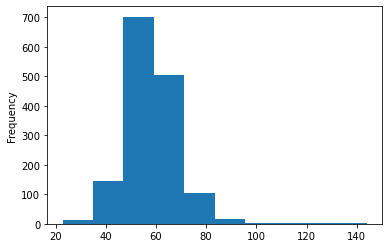

In [20]:
sleep_total = pd.Series([(df.interval == 'REST-S').sum() / 120 for df in train_data])
sleep_total.plot(kind = 'hist')

In [21]:
sleep_total.median()

57.4

<AxesSubplot:ylabel='Frequency'>

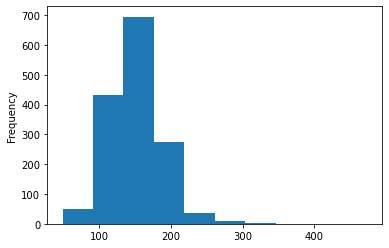

In [18]:
std_act = pd.Series([df.activity.std() for df in train_data])
std_act.plot(kind = 'hist')

In [1]:
import pandas as pd

In [4]:
pd.Series(['Good', 'Bad', 'Bad']).to_csv('lol.csv', index = False)

In [7]:
pd.read_csv('lol.csv')

,0
0,Good
1,Bad
2,Bad
